<a href="https://colab.research.google.com/github/nathalyAlarconT/GenAI_Workshops/blob/main/FunctionCalling_Rick_and_Morty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemini's Function Calling with Rick and Morty API

In [ ]:
!pip install --upgrade google-cloud-aiplatform --quiet

**Function Calling** Is a Gemini Functionality, where we can deliver a set of defined functions and according to the prompt received, Gemini will decide if it should use the provided defined function(s) to generate the response. The final response will be also provided in a friendly natural language.



You can find more information of Function calling here: https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling


**Goal of the tutorial**

In this tutorial, we will create a **Rick And Morty Expert** where we will allow the users to ask for factual information abour the TV Series: Rick and Morty. If we receive a generic prompt, Gemini will generate it's own response.


# Functions definition

In [ ]:
# Required Libraries
import requests
import json
import pandas as pd
# import plotly.express as px

## API to be used
We will call 3 different methods from the following API : https://rickandmortyapi.com



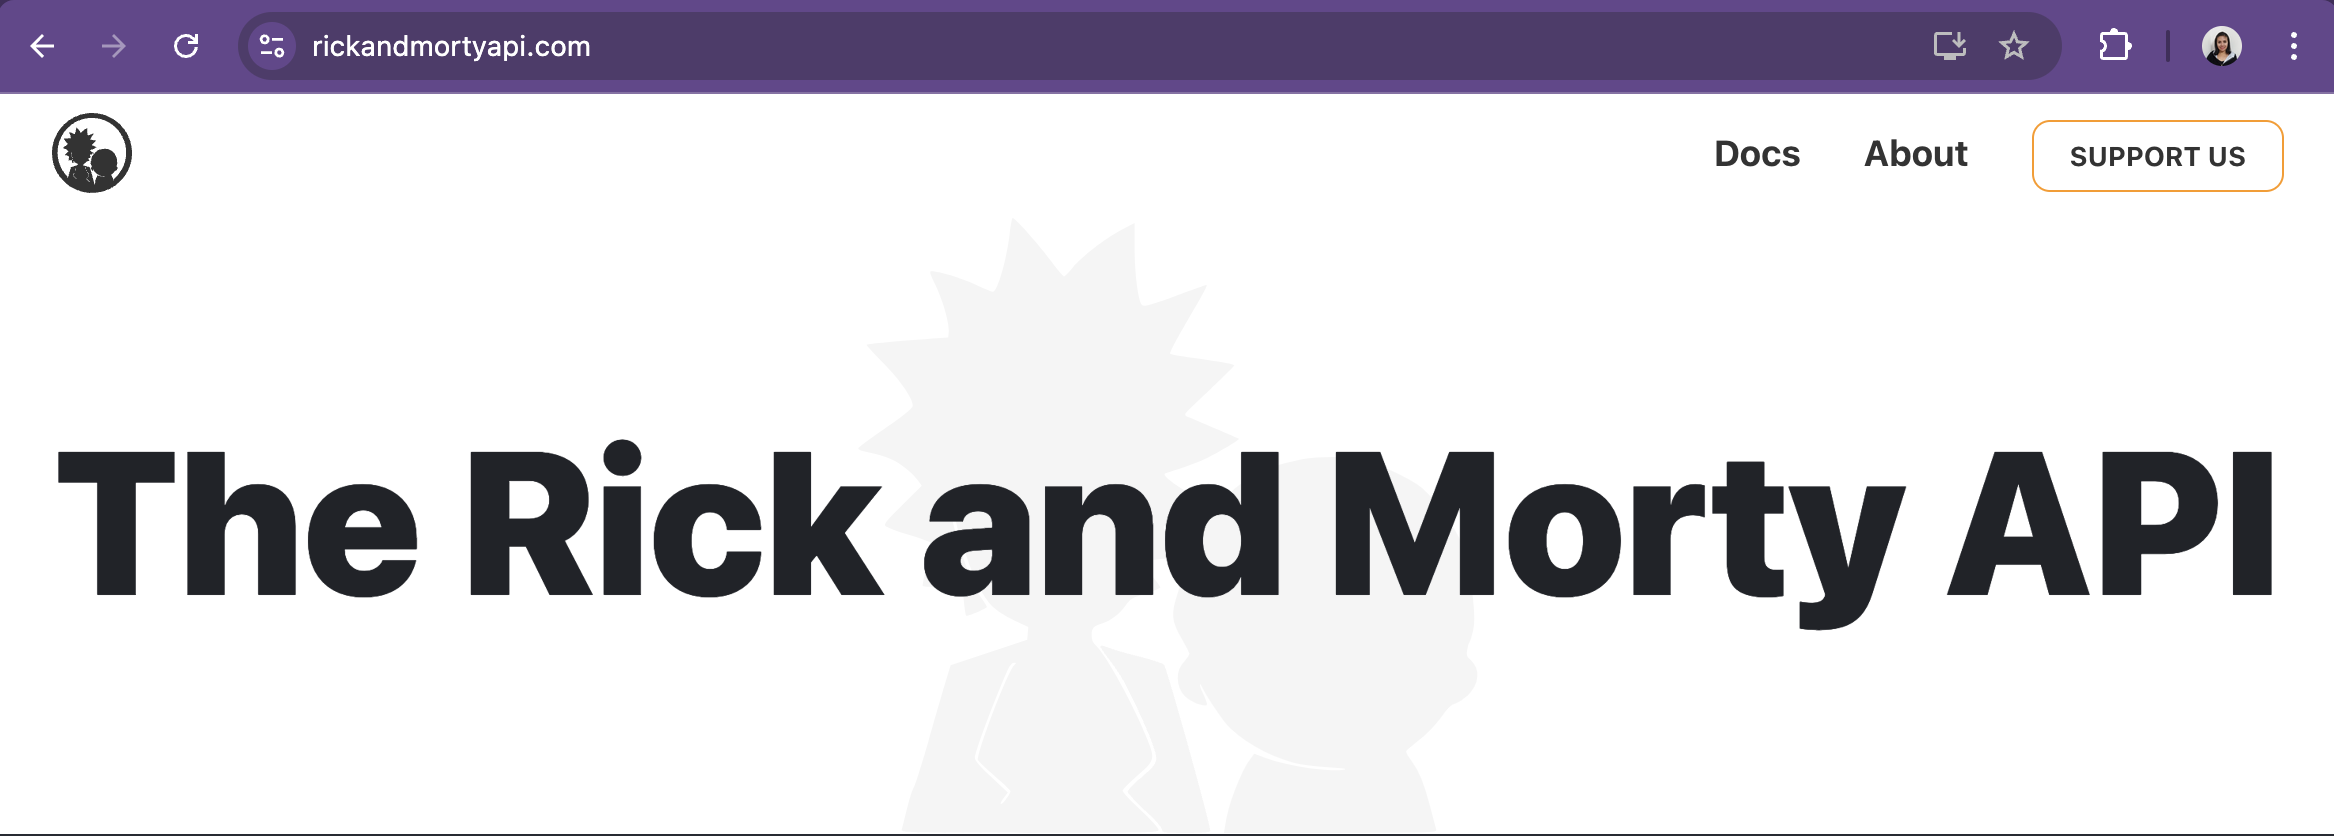

We will use the following methods:


1.   **Characters API** : https://rickandmortyapi.com/documentation/#filter-characters

      This method can receive the name, status, species, type or gender from the desired character that we want to retrieve info.

2.   **Location API** : https://rickandmortyapi.com/documentation/#filter-locations
      This method can provide information about an specific planet, dimension, etc, based on the name, type or dimension of the place.

3.   **Episodes API** : https://rickandmortyapi.com/documentation/#filter-episodes
      This method can provide information about an specific episode based on the name or code of the episode



As we have to build the url based on the function specification. We are going to add a generic function to add the availeble parameters to the API URL.

In [ ]:
def add_api_parameters(base_url, params):
    """Adds available parameters to an API URL.

    Args:
        base_url (str): The base URL of the API.
        params (dict): A dictionary containing parameter names and values.

    Returns:
        str: The updated URL with added parameters.
    """

    # Handle empty params
    if not params:
        return base_url

    # Create a query string from available parameters
    query_string = "&".join(f"{key}={value}" for key, value in params.items() if value is not None)

    # Append the query string to the base URL
    if query_string:
        return f"{base_url}?{query_string}"
    else:
        return base_url

In [ ]:
def search_for_a_character(params):
  """Searches for a character in the Rick and Morty API.

  Args:
    name: The name of the character.
    status: The status of the character (e.g., "Alive", "Dead", "unknown").
    species: The species of the character (e.g., "Human", "Alien").
    type: The type of the character .
    gender: The gender of the character (e.g., "Male", "Female").

  Returns:
    A JSON object containing the search results.
  """
  baseurl = "https://rickandmortyapi.com/api/character/"
  api_call_url = add_api_parameters(baseurl, params)
  print(api_call_url)
  response = requests.get(api_call_url)
  return json.loads(response.text)


In [ ]:
def search_for_a_location(params):
  """Searches for a location in the Rick and Morty API.

  Args:
    name: The name of the location.
    type: The type of the location (e.g., "Planet", "Cluster").
    dimension: The dimension of the location (e.g., "Dimension C-137").

  Returns:
    A JSON object containing the search results.
  """
  baseurl = "https://rickandmortyapi.com/api/location/"
  api_call_url = add_api_parameters(baseurl, params)
  print(api_call_url)
  response = requests.get(api_call_url)
  return json.loads(response.text)


In [ ]:
def search_for_an_episode(params):
  """Searches for an episode in the Rick and Morty API.

  Args:
    name: The name of the episode.
    episode: The episode code (e.g., "S01E01").

  Returns:
    A JSON object containing the search results.
  """
  baseurl = "https://rickandmortyapi.com/api/episode/"
  api_call_url = add_api_parameters(baseurl, params)
  print(api_call_url)
  response = requests.get(api_call_url)
  return json.loads(response.text)


Sample Call and result:
```
search_for_a_character({"name":"Morty Smith", "species": "Human", "status": "Alive"})
```

API Response format:
```
https://rickandmortyapi.com/api/character/?name=Morty Smith&species=Human&status=Alive
{'info': {'count': 3, 'pages': 1, 'next': None, 'prev': None},
 'results': [{'id': 2,
   'name': 'Morty Smith',
   'status': 'Alive',
   'species': 'Human',
   'type': '',
   'gender': 'Male',
   'origin': {'name': 'unknown', 'url': ''},
   'location': {'name': 'Citadel of Ricks',
    'url': 'https://rickandmortyapi.com/api/location/3'},
   'image': 'https://rickandmortyapi.com/api/character/avatar/2.jpeg',
   'episode': ['https://rickandmortyapi.com/api/episode/1',
    'https://rickandmortyapi.com/api/episode/2',
    ...,
    ],
   'url': 'https://rickandmortyapi.com/api/character/2',
   'created': '2017-11-04T18:50:21.651Z'},
 ]}
```



# Vertex AI Configuration

In [ ]:
# Required Libraries
import vertexai

from vertexai.generative_models import (
    Content,
    FunctionDeclaration,
    GenerativeModel,
    GenerationConfig,
    Part,
    Tool,
)

### GCP Project Settings

In [ ]:
# Let's authenticate our user
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
from google.colab import userdata

# Replace here your GCP PROJECT NAME and PROJECT LOCATION
GCP_PROJECT = userdata.get('GCP_Project')
GCP_PROJECT_LOCATION = userdata.get('GCP_Project_location')

vertexai.init(project=GCP_PROJECT, location=GCP_PROJECT_LOCATION)

# Function Calling Configuration

Let's define **search_for_a_character**, **search_for_an_episode**, and **search_for_a_location** as Functions to be used with Gemini.

It is important to define the function name and the parameters list and purpose.



In [ ]:
search_for_a_character_func = FunctionDeclaration(
    name = "search_for_a_character",
    description = "Search for a Rick and Morty series character. It returns info like location origin location, specie, status (alive), gender, current location and date created",
    parameters = {
        "type": "object",
        "properties": {
            "name": {
                "type": "string",
                "description": "Name of the character to search for"
            },
            "status": {
                "type": "string",
                "description": "Status of the character to search for it could be: alive, dead or unknown"
            },
            "species": {
                "type": "string",
                "description": "Species of the character to search for"
            },
            "type": {
                "type": "string",
                "description": "Type of the character to search for"
            },
            "gender": {
                "type": "string",
                "description": "Gender of the character to search for. Posible values: female, male, genderless or unknown"
            }
        },
        # "required": [
        #     "name"
        # ]
    }
)


In [ ]:
search_for_a_location_func = FunctionDeclaration(
    name = "search_for_a_location",
    description = "Search for a Rick and Morty series location, dimensions or planet. It returns information like the type, dimension and residents / characters that live there. Location.name can be used to search for the details.",
    parameters = {
        "type": "object",
        "properties": {
            "name": {
                "type": "string",
                "description": "Name of the location to search for"
            },
            "type": {
                "type": "string",
                "description": "Type of the location to search for. Example: Dimension, unknown, Space station, Planet,Microverse, Cluster, TV, Resort, Fantasy town, Dream, Game, Miniverse, etc"
            },
            "dimension": {
                "type": "string",
                "description": "Dimension of the location to search for. Posible values: unknown, Dimension C-137, Post-Apocalyptic Dimension, Fantasy Dimension, Dimension <Code>, Replacement Dimension, etc"
            }
        },

    }
)


In [ ]:
search_for_an_episode_func = FunctionDeclaration(
    name = "search_for_an_episode",
    description = "Search for a Rick and Morty episode detail",
    parameters = {
        "type": "object",
        "properties": {
            "name": {
                "type": "string",
                "description": "Name of the episode to search for"
            },
            "episode": {
                "type": "string",
                "description": "Episode Code Looked for"
            },

        },
    },
)


Now let's create a Tool object were we will add all the functions defined.

In [ ]:
rick_and_morty_tool = Tool(function_declarations = [search_for_a_character_func, search_for_a_location_func, search_for_an_episode_func])

## Gemini Flash with Function Calling Execution

We configure Gemini Flash model and as an extra parameter, we will send the Tools defined previously

In [ ]:
model = GenerativeModel("gemini-1.5-flash-001", generation_config=GenerationConfig(temperature=0), tools=[rick_and_morty_tool])

In [ ]:
chat = model.start_chat()

### Auxiliar functions to call Gemini and Function Calling

In [ ]:
def call_gemini_api(prompt):
  """Calls the Gemini API with the given prompt.

  Args:
    prompt: The prompt to send to the Gemini API.

  Returns:
    The text response from the Gemini API.
  """

  # Send the prompt to the Gemini API
  response = chat.send_message(prompt)


  # Check if the response contains a function call
  if response.candidates[0].content.parts[0].function_call:
    print("-----")
    print("*** Gemini is requesting to call a Function *** ")
    # Extract the text from the model response
    function_calling_result = call_a_function(response)
    # Return the final text from the function call
    return function_calling_result.text

  else:
    # print("Regular model call")
    # Return the text from the model response for a regular call
    # Without function calling.
    return response.text


In [ ]:
def call_a_function(response):
    """
    This function parses a response object containing a function call,
    constructs the function call string, executes it using eval,
    and returns the API response or makes another function call if necessary.

    Args:
        response: A response object containing the function call information.

    Returns:
        The API response or the response from another function call (recursive).
    """


    # Extract the function name from the response object
    func_name = response.candidates[0].content.parts[0].function_call.name
    calling_parameters_function = ""
    calling_parameters_object = {}


    # Loop through function call arguments and construct the argument string
    for param_name in response.candidates[0].content.parts[0].function_call.args:
      param_value = response.candidates[0].content.parts[0].function_call.args[param_name]
      calling_parameters_object[param_name] = param_value

    # Build final function call statement
    calling_function_string = f"{func_name}({calling_parameters_object})"
    print(calling_function_string)

    # Execute the call to the api within the defined function
    response_api = eval(calling_function_string)
    print(response_api)

    # Return the API response back to Gemini, so it can generate a model response or request another function call
    response = chat.send_message(
        Part.from_function_response(
            name= func_name,
            response={
                "content": response_api,
            },
        ),
    )

    # print(response)
    # Check if the response contains another function call
    if response.candidates[0].content.parts[0].function_call:
      # Make another recursive function call if there's another function call
      print("Make a new function call")
      response_function = call_a_function(response)
      return response_function
    else:
      # If no more function calls, return the response
      # print("No more API calls")
      return response

# Prompt Execution

In some cases , the model can call multiple functions before providing a response. For example:
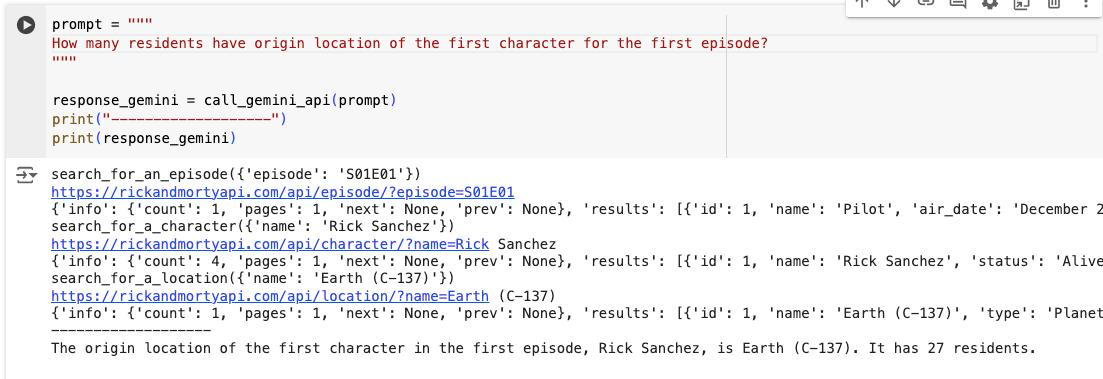

We can start asking questions about characters, locations and episodes :)

In [ ]:
prompt = """
In how many episodes does Rick Sanchez appear?
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

-----
*** Gemini is requesting to call a Function *** 
search_for_a_character({'name': 'Rick Sanchez'})
https://rickandmortyapi.com/api/character/?name=Rick Sanchez
{'info': {'count': 4, 'pages': 1, 'next': None, 'prev': None}, 'results': [{'id': 1, 'name': 'Rick Sanchez', 'status': 'Alive', 'species': 'Human', 'type': '', 'gender': 'Male', 'origin': {'name': 'Earth (C-137)', 'url': 'https://rickandmortyapi.com/api/location/1'}, 'location': {'name': 'Citadel of Ricks', 'url': 'https://rickandmortyapi.com/api/location/3'}, 'image': 'https://rickandmortyapi.com/api/character/avatar/1.jpeg', 'episode': ['https://rickandmortyapi.com/api/episode/1', 'https://rickandmortyapi.com/api/episode/2', 'https://rickandmortyapi.com/api/episode/3', 'https://rickandmortyapi.com/api/episode/4', 'https://rickandmortyapi.com/api/episode/5', 'https://rickandmortyapi.com/api/episode/6', 'https://rickandmortyapi.com/api/episode/7', 'https://rickandmortyapi.com/api/episode/8', 'https://rickandmortyapi.com/api

In [ ]:
prompt = """
In which episode does Rick Sanchez first appear?
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

-----
*** Gemini is requesting to call a Function *** 
search_for_a_character({'name': 'Rick Sanchez'})
https://rickandmortyapi.com/api/character/?name=Rick Sanchez
{'info': {'count': 4, 'pages': 1, 'next': None, 'prev': None}, 'results': [{'id': 1, 'name': 'Rick Sanchez', 'status': 'Alive', 'species': 'Human', 'type': '', 'gender': 'Male', 'origin': {'name': 'Earth (C-137)', 'url': 'https://rickandmortyapi.com/api/location/1'}, 'location': {'name': 'Citadel of Ricks', 'url': 'https://rickandmortyapi.com/api/location/3'}, 'image': 'https://rickandmortyapi.com/api/character/avatar/1.jpeg', 'episode': ['https://rickandmortyapi.com/api/episode/1', 'https://rickandmortyapi.com/api/episode/2', 'https://rickandmortyapi.com/api/episode/3', 'https://rickandmortyapi.com/api/episode/4', 'https://rickandmortyapi.com/api/episode/5', 'https://rickandmortyapi.com/api/episode/6', 'https://rickandmortyapi.com/api/episode/7', 'https://rickandmortyapi.com/api/episode/8', 'https://rickandmortyapi.com/api

In [ ]:
prompt = """
Who is Beth Smith, and where is she from?
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

-----
*** Gemini is requesting to call a Function *** 
search_for_a_character({'name': 'Beth Smith'})
https://rickandmortyapi.com/api/character/?name=Beth Smith
{'info': {'count': 4, 'pages': 1, 'next': None, 'prev': None}, 'results': [{'id': 4, 'name': 'Beth Smith', 'status': 'Alive', 'species': 'Human', 'type': '', 'gender': 'Female', 'origin': {'name': 'Earth (Replacement Dimension)', 'url': 'https://rickandmortyapi.com/api/location/20'}, 'location': {'name': 'Earth (Replacement Dimension)', 'url': 'https://rickandmortyapi.com/api/location/20'}, 'image': 'https://rickandmortyapi.com/api/character/avatar/4.jpeg', 'episode': ['https://rickandmortyapi.com/api/episode/6', 'https://rickandmortyapi.com/api/episode/7', 'https://rickandmortyapi.com/api/episode/8', 'https://rickandmortyapi.com/api/episode/9', 'https://rickandmortyapi.com/api/episode/10', 'https://rickandmortyapi.com/api/episode/11', 'https://rickandmortyapi.com/api/episode/12', 'https://rickandmortyapi.com/api/episode/14', '

In [ ]:
prompt = """
In which episode does Gene first appear, and what is the location?
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

-----
*** Gemini is requesting to call a Function *** 
search_for_a_character({'name': 'Gene'})
https://rickandmortyapi.com/api/character/?name=Gene
{'info': {'count': 6, 'pages': 1, 'next': None, 'prev': None}, 'results': [{'id': 137, 'name': 'Gene', 'status': 'Alive', 'species': 'Human', 'type': '', 'gender': 'Male', 'origin': {'name': 'Earth (Replacement Dimension)', 'url': 'https://rickandmortyapi.com/api/location/20'}, 'location': {'name': 'Earth (Replacement Dimension)', 'url': 'https://rickandmortyapi.com/api/location/20'}, 'image': 'https://rickandmortyapi.com/api/character/avatar/137.jpeg', 'episode': ['https://rickandmortyapi.com/api/episode/26', 'https://rickandmortyapi.com/api/episode/49'], 'url': 'https://rickandmortyapi.com/api/character/137', 'created': '2017-12-27T18:14:57.885Z'}, {'id': 138, 'name': 'General Nathan', 'status': 'Dead', 'species': 'Human', 'type': '', 'gender': 'Male', 'origin': {'name': 'Earth (Replacement Dimension)', 'url': 'https://rickandmortyapi.co

In [ ]:
prompt = """
How many episodes take place at the Citadel of Ricks?
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

-----
*** Gemini is requesting to call a Function *** 
search_for_a_location({'name': 'Citadel of Ricks'})
https://rickandmortyapi.com/api/location/?name=Citadel of Ricks
{'info': {'count': 1, 'pages': 1, 'next': None, 'prev': None}, 'results': [{'id': 3, 'name': 'Citadel of Ricks', 'type': 'Space station', 'dimension': 'unknown', 'residents': ['https://rickandmortyapi.com/api/character/8', 'https://rickandmortyapi.com/api/character/14', 'https://rickandmortyapi.com/api/character/15', 'https://rickandmortyapi.com/api/character/18', 'https://rickandmortyapi.com/api/character/21', 'https://rickandmortyapi.com/api/character/22', 'https://rickandmortyapi.com/api/character/27', 'https://rickandmortyapi.com/api/character/42', 'https://rickandmortyapi.com/api/character/43', 'https://rickandmortyapi.com/api/character/44', 'https://rickandmortyapi.com/api/character/48', 'https://rickandmortyapi.com/api/character/53', 'https://rickandmortyapi.com/api/character/56', 'https://rickandmortyapi.com/a

In [ ]:
prompt = """
What is the title of the first episode of the second season?
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

-----
*** Gemini is requesting to call a Function *** 
search_for_an_episode({'episode': 'S02E01'})
https://rickandmortyapi.com/api/episode/?episode=S02E01
{'info': {'count': 1, 'pages': 1, 'next': None, 'prev': None}, 'results': [{'id': 12, 'name': 'A Rickle in Time', 'air_date': 'July 26, 2015', 'episode': 'S02E01', 'characters': ['https://rickandmortyapi.com/api/character/1', 'https://rickandmortyapi.com/api/character/2', 'https://rickandmortyapi.com/api/character/3', 'https://rickandmortyapi.com/api/character/4', 'https://rickandmortyapi.com/api/character/5', 'https://rickandmortyapi.com/api/character/11', 'https://rickandmortyapi.com/api/character/64', 'https://rickandmortyapi.com/api/character/237', 'https://rickandmortyapi.com/api/character/313', 'https://rickandmortyapi.com/api/character/437', 'https://rickandmortyapi.com/api/character/438', 'https://rickandmortyapi.com/api/character/439', 'https://rickandmortyapi.com/api/character/440'], 'url': 'https://rickandmortyapi.com/api

Now let's make a generic question. Gemini won't call any function and will generate the response.

In [ ]:
prompt = """
What other similar TV series to Rick and Morty would you suggest?
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

-------------------
While I can't provide specific recommendations based on your personal preferences, here are some TV series that share similar themes and elements with Rick and Morty, which you might enjoy:

**Sci-fi Comedy:**

* **Solar Opposites (Hulu):**  A family of aliens crash-lands on Earth and struggles to adapt to human culture. It features similar dark humor and sci-fi concepts as Rick and Morty.
* **Final Space (Netflix):** A space explorer befriends a sentient planet and embarks on a journey to save the universe. It has a similar blend of humor, action, and emotional depth.
* **The Venture Bros. (Adult Swim):** A parody of classic superhero shows, featuring a dysfunctional family of supervillains. It has a similar satirical edge and quirky characters.

**Adult Animation:**

* **BoJack Horseman (Netflix):** A cynical, alcoholic horse struggles with fame, addiction, and his past. It explores mature themes with a darkly comedic tone.
* **Archer (FX):** A spy comedy featurin

--------------------------



*Google AI/ML Developer Programs team supported this work by providing Google Cloud Credits*